## Anomaly Detection in Time Series Sensor Data

### Random Forest

- Random forest is one of the ensemble algorithms.
- Based on many decision trees
- Be careful about max_depth parameter (higher value means overfitting)
- Hard for interpretation

CRISP - DM methodology:

- Business understanding
- Data understanding
- Data transformation
- Modeling
- Evaluation
- Deployment

### Business understanding

- The data are from sensors of water pump in one small town.

- There are 53 sensors intalled on that pump and they are actually KPIs for monitoring behaviour of the pump.

- The task is to detect unusual behaviour of the pump (failures)

- What is Time Series?

A Time Series is a sequence taken at successive equally spaced points in time. It is very important to emphasize role of time here. Observations are depending on time.

### Python Libraries

Libraries that are needed for this notebook:

- pandas - python library for working with data
- numpy - python library for different kind of calculations
- scikit-learn - python library for ML models
- matplotlib and seaborn - python libraries for visualizations

Installing libraries:

- in notebook: !pip install numpy

- in terminal: pip install numpy

Requirements:

- numpy==1.19.5
- pandas==1.1.5
- scikit-learn==0.23.1
- matplotlib==3.3.2
- seaborn==0.9.0

Checking the version of library: 
- pip freeze | grep scikit-learn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

### Data understanding

We will download dataset from Kaggle: 
https://www.kaggle.com/nphantawee/pump-sensor-data

In [5]:
df = pd.read_csv("../data/sensor.csv")

In [7]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [9]:
df.shape

(220320, 55)

In [11]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

Columns:
    
- timestamp - datetime when sensor have read value
- sensor_00-51 - names of sensors
- machine_status - column that shows if machine was in normal state, in failure or in recovering

Column Unnamed is sufficient, so we will drop it

In [13]:
df.drop(columns='Unnamed: 0', inplace=True)

In [14]:
df.columns

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23',
       'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28',
       'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33',
       'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38',
       'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43',
       'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48',
       'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [15]:
df.dtypes

timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36         float64
sensor_37   

It is important to check types of columns, especially if date is categorical value (type object), we need to cast it to date:

- df['date_column'] = pd.to_datetime(df['date_column'])

If we want to cast object value to integer or float:

- df['kolona_koju_pretvaramo'] = df['kolona_koju_pretvaramo'].astype(int)

- df['kolona_koju_pretvaramo'] = df['kolona_koju_pretvaramo'].astype(float)

In [16]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [17]:
df.dtypes

timestamp         datetime64[ns]
sensor_00                float64
sensor_01                float64
sensor_02                float64
sensor_03                float64
sensor_04                float64
sensor_05                float64
sensor_06                float64
sensor_07                float64
sensor_08                float64
sensor_09                float64
sensor_10                float64
sensor_11                float64
sensor_12                float64
sensor_13                float64
sensor_14                float64
sensor_15                float64
sensor_16                float64
sensor_17                float64
sensor_18                float64
sensor_19                float64
sensor_20                float64
sensor_21                float64
sensor_22                float64
sensor_23                float64
sensor_24                float64
sensor_25                float64
sensor_26                float64
sensor_27                float64
sensor_28                float64
sensor_29 

In [19]:
df.isnull().sum()

timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16
sensor_38             27


We can see that sensor_15 doesn't have any value, so we can drop that column.

All of the other sensor have missing values, more or less. Now we will calculate percentage of missing values to see if is it worth filling it out or we should drop more columns. It is practice to drop every column that has more than 70% of missing values.


In [20]:
def calculate_na_percentage(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df)*100,
                        columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [21]:
calculate_na_percentage(df).head(10)

,percent
sensor_15,100.000000
sensor_50,34.956881
sensor_51,6.982117
sensor_00,4.633261
sensor_07,2.474129
sensor_08,2.317992
sensor_06,2.177741
sensor_09,2.085603
sensor_01,0.167484
sensor_30,0.118464


Percentage of missing values is low for every columns, so we will drop only column sensor_15. For the rest of the columns we need to fill missing values and we will do that with help of IterativeImputer.

IterativeImputer fills every column depending on all other columns. It can be used only for numerical columns.

In [22]:
df.drop(columns='sensor_15', inplace=True)

In [23]:
# get all the columns which missing values we want to fill in
features = df.columns
features = [feature for feature in features if feature not in ['timestamp', 'machine_status']]

In [26]:
%%time
df[features] = IterativeImputer().fit_transform(df[features])

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


CPU times: user 44min 37s, sys: 5min 37s, total: 50min 15s
Wall time: 9min 7s


In [27]:
df.isna().sum()

timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0


In [28]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,...,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,2.261848,47.591444,50.867360,43.752488,590.672891,73.396496,13.346728,15.662962,15.036931,14.681360,...,35.453437,43.879539,42.656840,43.095068,48.018665,44.340863,150.890735,57.120139,209.760311,206.687502
std,0.644540,3.294353,3.666668,2.418783,144.017843,17.297522,2.397737,2.503575,2.319918,2.234783,...,10.258897,11.043730,11.575690,12.836742,15.640337,10.441807,82.240433,19.142489,68.210833,110.672834
min,-0.480434,0.000000,33.159720,31.640620,2.798032,0.000000,-0.061440,-0.765181,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,-318.281458,-345.717914
25%,2.419155,46.310760,50.390620,42.838539,626.620400,69.977213,13.317420,15.856480,15.147570,15.010130,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,182.002300,179.710887
50%,2.455556,48.133678,51.649300,44.227428,632.638916,75.576590,13.628470,16.167530,15.451390,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,214.975251,199.363400
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.911770,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,252.849521,219.907400
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [29]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [31]:
print('Min date in dataset:', df['timestamp'].min().date())
print('Max date in dataset:', df['timestamp'].max().date())

Min date in dataset: 2018-04-01
Max date in dataset: 2018-08-31


In [4]:
train_data_minute = pd.read_csv('../data/train_data.csv')
train_data_minute['timestamp'] = pd.to_datetime(train_data_minute['timestamp'])

In [5]:
# aggregating data on hourly level
train_data_hourly = train_data_minute.set_index('timestamp').resample('H').sum()

In [6]:
train_data = train_data_minute

### Visualizations

In [7]:
train_data = train_data.sort_values(by='timestamp') 

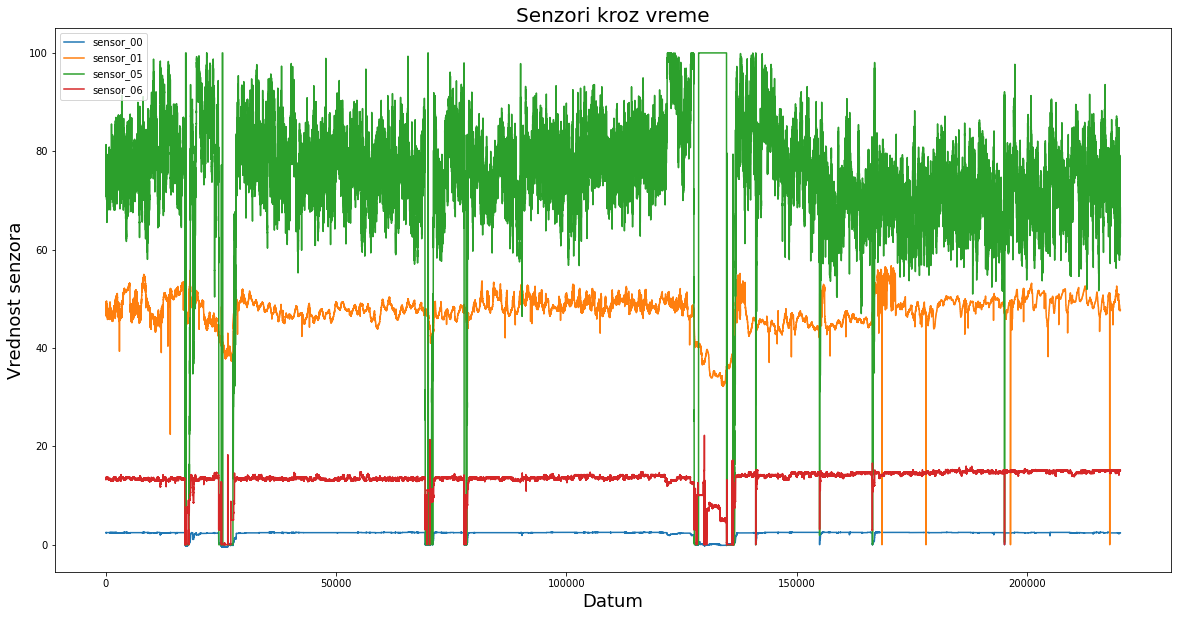

In [8]:
train_data[['sensor_00','sensor_01', 'sensor_05', 'sensor_06']].plot(figsize=(20,10))
plt.xlabel("Datum", fontsize=18)
plt.ylabel("Vrednost senzora", fontsize=18)
plt.title('Senzori kroz vreme', fontsize=20);

In [9]:
train_data_minute[train_data_minute['machine_status']=='BROKEN'].head(100)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.652800,BROKEN
24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.738400,BROKEN
69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.523100,BROKEN
77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.361100,BROKEN
128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,169.719892,BROKEN
141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.768500,BROKEN
166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,269.655985,205.729200,BROKEN


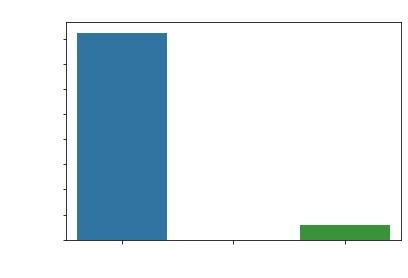

In [10]:
sns.countplot(train_data_minute['machine_status'], data=train_data_minute)

plt.title("Ratio of machine statuses", color='white')
plt.ylabel('Count of observations', color='white')
plt.xlabel('Machine status', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

In [11]:
corr_matrix = train_data.corr().abs()

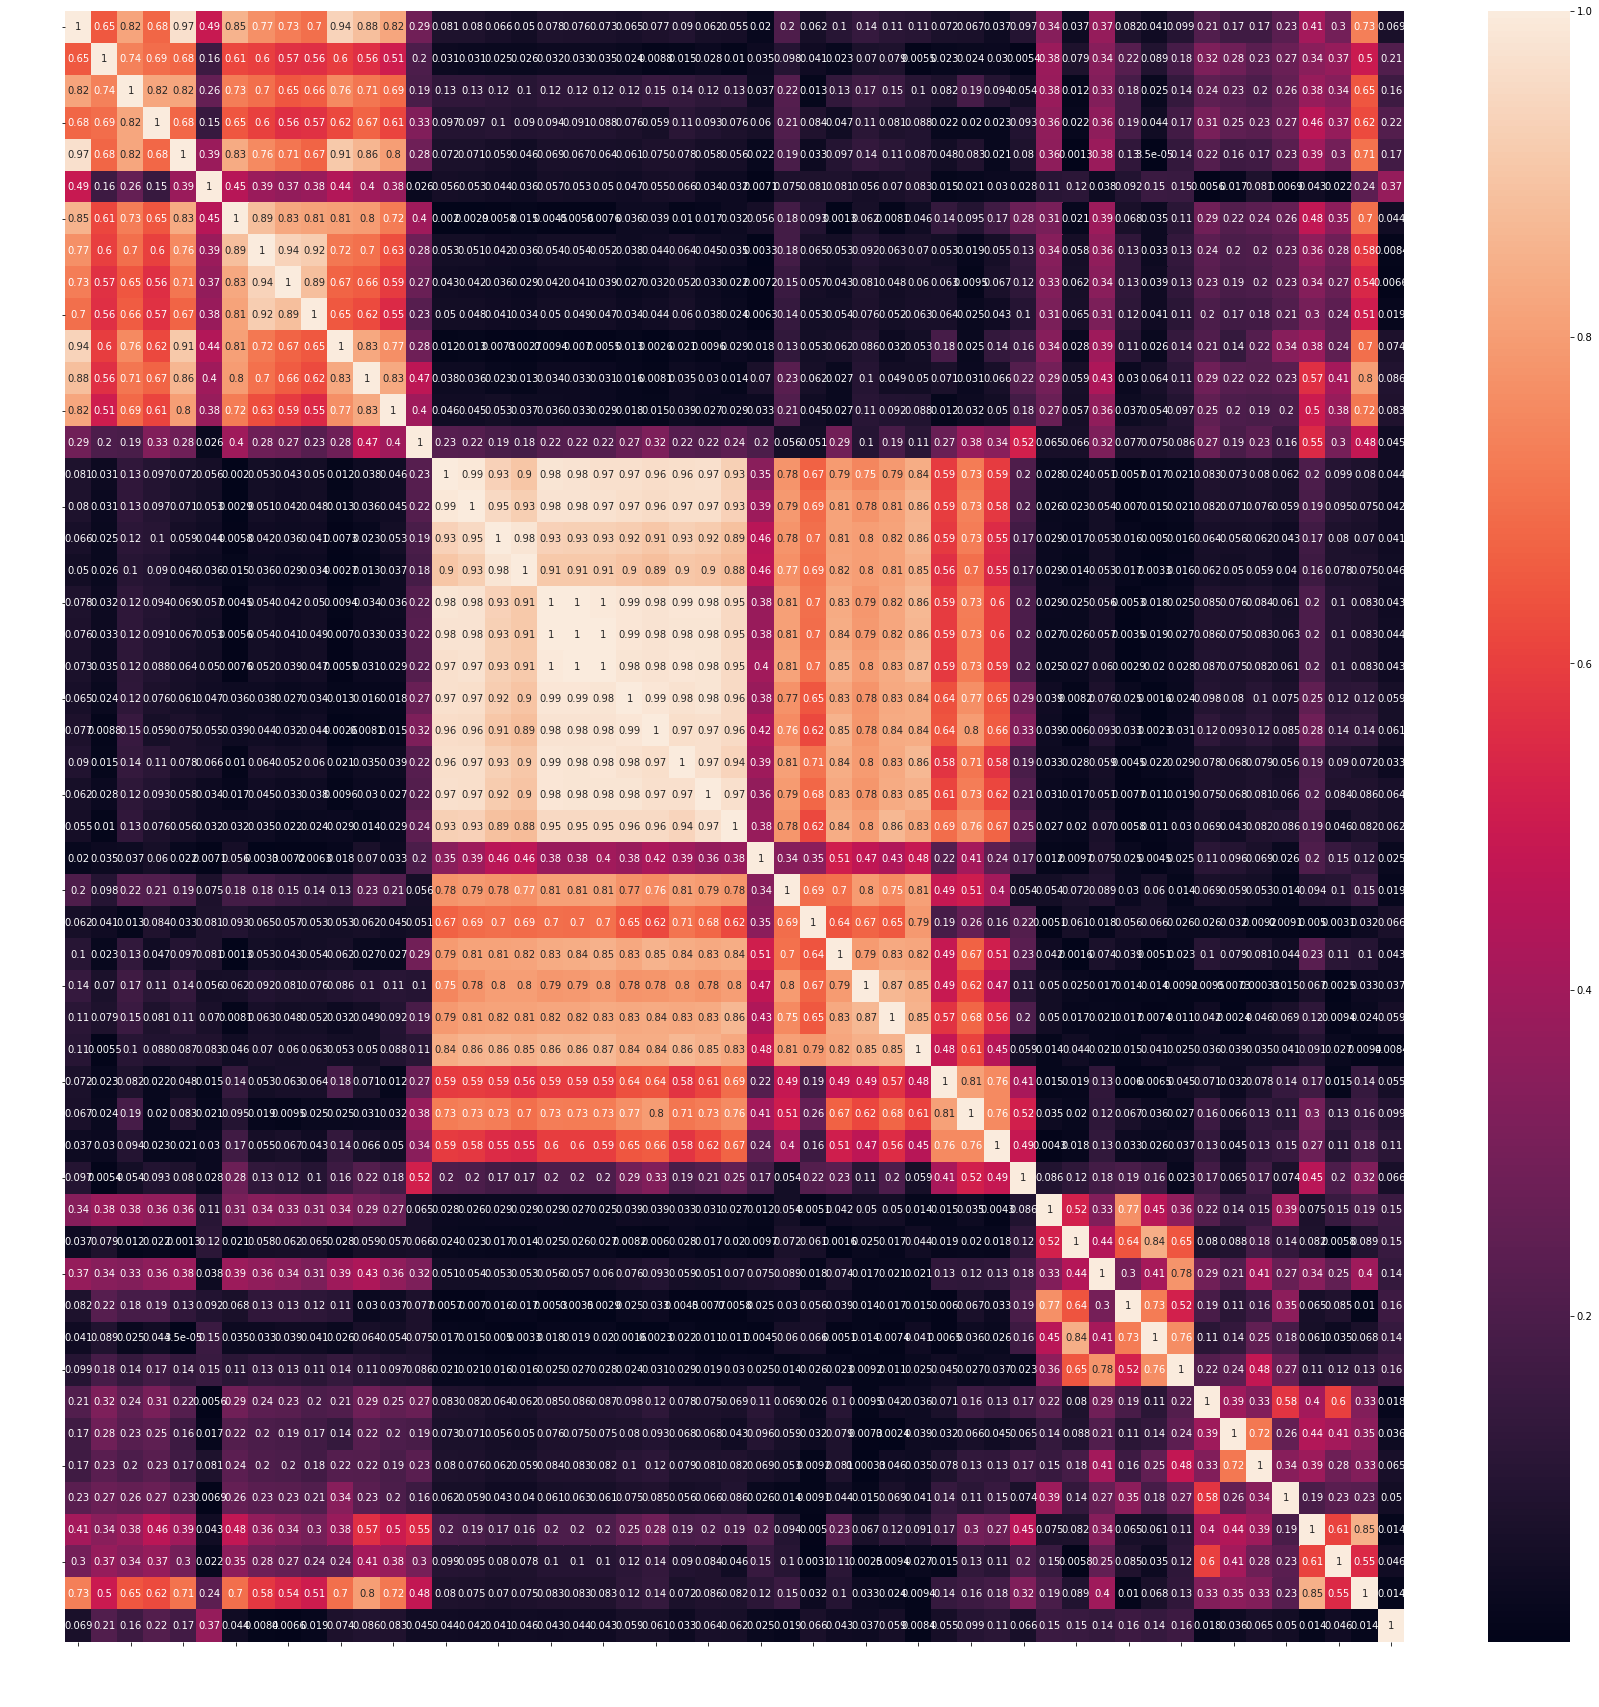

In [12]:
sns.heatmap(corr_matrix, annot=True) # everything above 0.8 is high correlation and can be dropped
plt.gcf().set_size_inches(30, 30)
plt.xticks(color='white')
plt.yticks(color='white');

In [13]:
dates_broken = train_data_minute[train_data_minute['machine_status']=='BROKEN']['timestamp']

In [14]:
train_data

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.055600,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.055600,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.319400,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.451400,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.187500,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,262.386623,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,264.696257,231.1921,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,266.983221,232.0602,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,270.588287,234.0856,NORMAL


- Conclusion based on visualization is that we can predict failure based on sensors, in this case the sensor_05 is the most valuable.

### Data preparation

Here we can have scaling, normalizing of the data, train and test spit, etc.

In [15]:
#Creating the dependent variable class
factor = pd.factorize(train_data['machine_status'])
train_data.machine_status = factor[0]
definitions = factor[1]
print(train_data.machine_status.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: machine_status, dtype: int64
Index(['NORMAL', 'BROKEN', 'RECOVERING'], dtype='object')


In [16]:
train = train_data[train_data['timestamp']<'2018-07-01']
train.set_index('timestamp', inplace=True)

test = train_data[train_data['timestamp']>='2018-07-01']
test.set_index('timestamp', inplace=True)

In [17]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

### Modeling

Parameters for optimization:

- n_estimators - number of decision trees
- max_depth - depth of the decision trees (optimal up to 10)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [18]:
RF = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample')
rf_model = RF.fit(X_train, y_train)

### Prediction

In [19]:
y_pred = rf_model.predict(X_test)

### Evaluation

In [20]:
#Reverse factorize (converting y_pred from 0s,1s and 2s to categorical)
reversefactor = dict(zip(range(3),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)

In [21]:
# Making the Confusion Matrix
pd.DataFrame(pd.crosstab(y_test, y_pred, rownames=['Actual Machine Status'], colnames=['Predicted Machine Status']))

Predicted Machine Status,NORMAL,RECOVERING
Actual Machine Status,,
BROKEN,2,0
NORMAL,83637,134
RECOVERING,114,5393


The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes.

- multi_class{‘raise’, ‘ovr’, ‘ovo’} - Only used for multiclass targets. Determines the type of configuration to use.

    - 'ovr': Stands for One-vs-rest. Computes the AUC of each class against the rest. This treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance.

    - 'ovo': Stands for One-vs-one. Computes the average AUC of all possible pairwise combinations of classes. Insensitive to class imbalance.

In [22]:
roc_auc_score(y_test, RF.predict_proba(X_test), multi_class='ovo')

0.6496947989211506

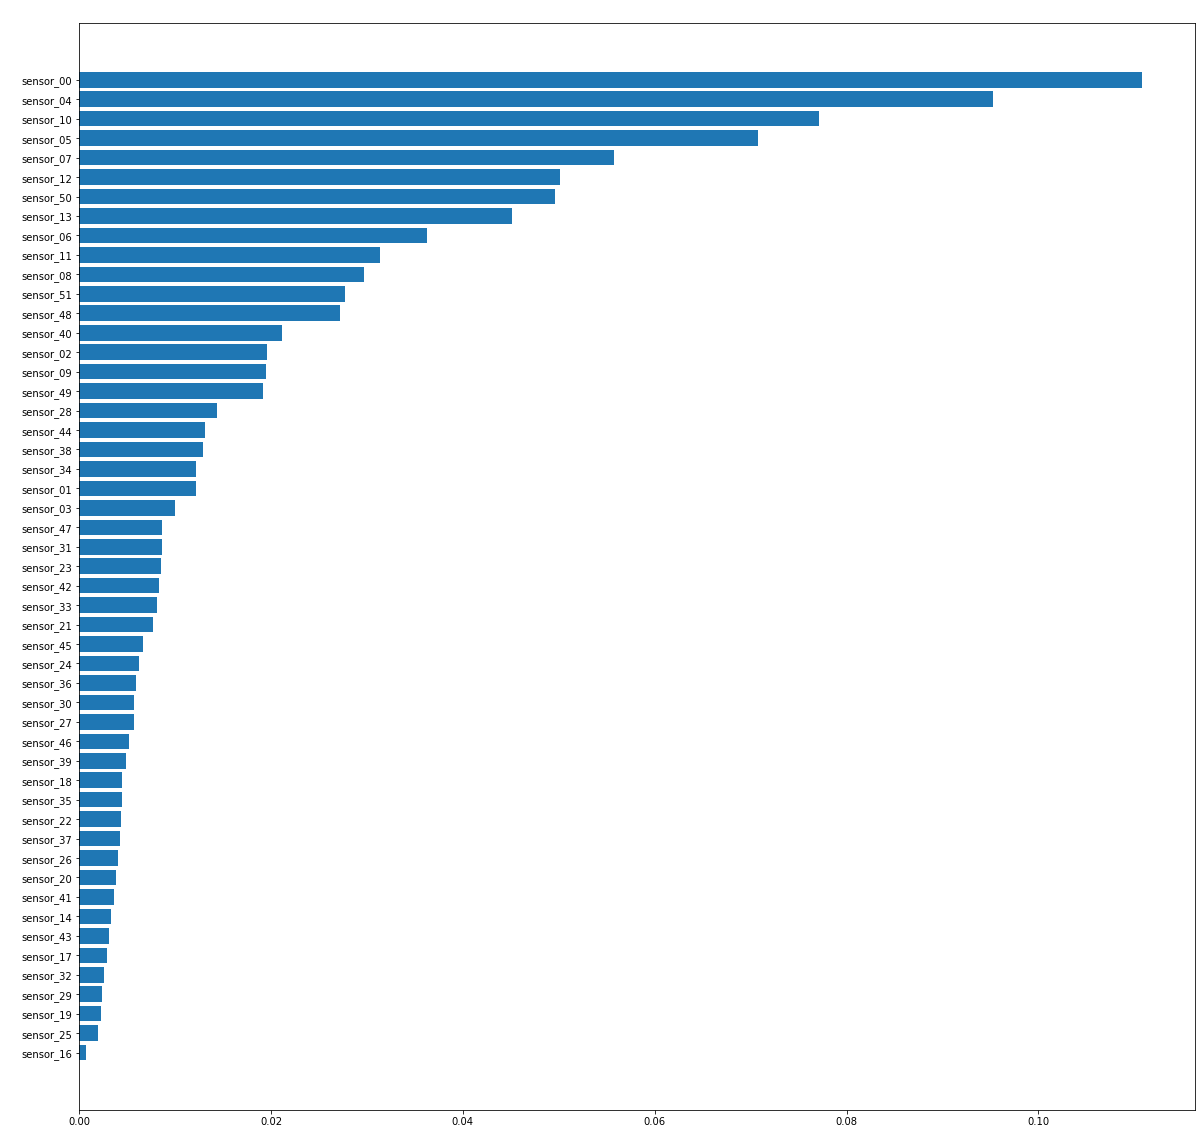

In [23]:
plt.figure(figsize = (20,20))
imp = rf_model.feature_importances_
names = X_test.columns
imp,names = zip(*sorted(zip(imp, names)))
plt.barh(range(len(names)),imp, align='center')
plt.yticks(range(len(names)),names)
plt.xlabel('Feature importance', color='white')
plt.ylabel('Columns', color='white')
plt.title('Feature importance random forest', color='white')
plt.show();